<a href="https://colab.research.google.com/github/cyclingdata/kaggle_fraud_modelling/blob/master/Model_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Apply catboost models for Kaggle Fraud detection competition

Install catboost

In [0]:
!pip install catboost shap ipywidgets sklearn
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 62.5MB 1.4MB/s 
     |████████████████████████████████| 245kB 53.4MB/s 
  Created wheel for shap: filename=shap-0.30.1-cp36-cp36m-linux_x86_64.whl size=360445 sha256=a2d5da55e32bebf06aa387f56aa894e5e4ae5e6dffb04d70849078dcc2475c60
  Stored in directory: /root/.cache/pip/wheels/62/94/5e/feb9af12d63a719a32266a29ca564b4dc37b4755052aca6859
Successfully built shap
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Connect to Google account to download data stored on GCP

In [0]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

Import needed libraries

In [0]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import pickle

Download train and test datasets from GCP

In [0]:
!gsutil cp gs://data-fraud-detection/X_train_cat.parquet X_train_cat.parquet
X_train_new = pd.read_parquet('X_train_cat.parquet')

Copying gs://data-fraud-detection/X_train_cat.parquet...
/ [1 files][103.2 MiB/103.2 MiB]                                                
Operation completed over 1 objects/103.2 MiB.                                    


In [0]:
!gsutil cp gs://data-fraud-detection/X_test_cat.parquet X_test_cat.parquet
X_test_new = pd.read_parquet('X_test_cat.parquet')

Copying gs://data-fraud-detection/X_test_cat.parquet...
| [1 files][ 26.9 MiB/ 26.9 MiB]                                                
Operation completed over 1 objects/26.9 MiB.                                     


In [0]:
!gsutil cp gs://data-fraud-detection/y_train_values.pickle y_train_values.pickle
y_train_values = pickle.load(open('y_train_values.pickle','rb'))
!rm y_train_values.pickle

Copying gs://data-fraud-detection/y_train_values.pickle...
\ [1 files][ 10.8 MiB/ 10.8 MiB]                                                
Operation completed over 1 objects/10.8 MiB.                                     


In [0]:
X_train_new.shape

(472432, 519)

In [0]:
X_train_new.drop(columns=['TransactionID','index_row','device_version'],inplace=True)
X_test_new.drop(columns=['TransactionID','index_row','device_version'],inplace=True)

In [0]:
!gsutil cp gs://data-fraud-detection/y_test_values.pickle y_test_values.pickle
y_test_values = pickle.load(open('y_test_values.pickle','rb'))
!rm y_test_values.pickle

Copying gs://data-fraud-detection/y_test_values.pickle...
- [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


In [0]:
!gsutil cp gs://data-fraud-detection/categorical_features.pickle categorical_features.pickle
categorical_features= pickle.load(open('categorical_features.pickle','rb'))
!rm categorical_features.pickle

Copying gs://data-fraud-detection/categorical_features.pickle...
- [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.                                      


In [0]:
cat_features = []

for i in range(X_train_new.shape[1]):
  if X_train_new.columns[i] in categorical_features:
    cat_features.append(i)
    
print(len(cat_features))
print(len(categorical_features))

64
64


In [0]:
from catboost import Pool

train_pool = Pool(
    data=X_train_new, 
    label=y_train_values, 
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_test_new, 
    label=y_test_values, 
    cat_features=cat_features
)

In [0]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    # loss_function='CrossEntropy',
    min_data_in_leaf =12,
    one_hot_max_size=125,
    task_type="GPU",
    early_stopping_rounds=100,
    max_ctr_complexity=2
)
model.fit(train_pool, eval_set=validation_pool, verbose=50)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))



0:	learn: 0.6358024	test: 0.6357334	best: 0.6357334 (0)	total: 111ms	remaining: 1m 51s
50:	learn: 0.0977647	test: 0.0942039	best: 0.0942039 (50)	total: 3.93s	remaining: 1m 13s
100:	learn: 0.0800228	test: 0.0751255	best: 0.0751255 (100)	total: 7.63s	remaining: 1m 7s
150:	learn: 0.0749970	test: 0.0695576	best: 0.0695576 (150)	total: 11.3s	remaining: 1m 3s
200:	learn: 0.0719534	test: 0.0662360	best: 0.0662360 (200)	total: 15s	remaining: 59.7s
250:	learn: 0.0696270	test: 0.0637153	best: 0.0637153 (250)	total: 18.8s	remaining: 56.1s
300:	learn: 0.0679821	test: 0.0618282	best: 0.0618282 (300)	total: 22.8s	remaining: 52.9s
350:	learn: 0.0668408	test: 0.0606123	best: 0.0606123 (350)	total: 26.7s	remaining: 49.3s
400:	learn: 0.0658013	test: 0.0595014	best: 0.0595014 (400)	total: 30.7s	remaining: 45.9s
450:	learn: 0.0647656	test: 0.0584082	best: 0.0584082 (450)	total: 34.7s	remaining: 42.3s
500:	learn: 0.0640168	test: 0.0576392	best: 0.0576392 (500)	total: 38.8s	remaining: 38.7s
550:	learn: 0.06

In [0]:

fi_array=np.array(model.get_feature_importance(prettified=True))
df_feature_importance = pd.DataFrame({'feature': fi_array[:,0],'feature_importance': fi_array[:,1]})

In [0]:
features_ok = df_feature_importance.loc[df_feature_importance.feature_importance >=0.05].feature
len(features_ok)

171

In [0]:
new_cat_features = []

X_train_trunc = X_train_new[features_ok]
X_test_trunc = X_test_new[features_ok]
for i in range(X_train_trunc.shape[1]):
  if X_train_trunc.columns[i] in categorical_features and X_train_trunc.columns[i] in features_ok.tolist():
    new_cat_features.append(i)

In [0]:
len(new_cat_features)

32

In [0]:
train_pool = Pool(
    data=X_train_trunc, 
    label=y_train_values, 
    cat_features=new_cat_features
)

validation_pool = Pool(
    data=X_test_trunc, 
    label=y_test_values, 
    cat_features=new_cat_features
)

In [0]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=8000,
    learning_rate=0.01,
    # loss_function='CrossEntropy',
    min_data_in_leaf =12,
    one_hot_max_size=200,
    task_type="GPU",
    early_stopping_rounds=100,
    max_ctr_complexity=2
)
model.fit(train_pool, eval_set=validation_pool, verbose=50)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

0:	learn: 0.6741512	test: 0.6741073	best: 0.6741073 (0)	total: 118ms	remaining: 15m 44s
50:	learn: 0.2207387	test: 0.2190764	best: 0.2190764 (50)	total: 3.6s	remaining: 9m 21s
100:	learn: 0.1262461	test: 0.1233915	best: 0.1233915 (100)	total: 7.15s	remaining: 9m 19s
150:	learn: 0.0982756	test: 0.0945788	best: 0.0945788 (150)	total: 10.9s	remaining: 9m 26s
200:	learn: 0.0880753	test: 0.0837105	best: 0.0837105 (200)	total: 14.5s	remaining: 9m 22s
250:	learn: 0.0828551	test: 0.0780974	best: 0.0780974 (250)	total: 18s	remaining: 9m 17s
300:	learn: 0.0797857	test: 0.0747092	best: 0.0747092 (300)	total: 21.6s	remaining: 9m 11s
350:	learn: 0.0774931	test: 0.0722010	best: 0.0722010 (350)	total: 25.1s	remaining: 9m 6s
400:	learn: 0.0759919	test: 0.0705839	best: 0.0705839 (400)	total: 28.6s	remaining: 9m 1s
450:	learn: 0.0746218	test: 0.0690621	best: 0.0690621 (450)	total: 32.2s	remaining: 8m 58s
500:	learn: 0.0734276	test: 0.0677643	best: 0.0677643 (500)	total: 35.7s	remaining: 8m 54s
550:	lear

In [0]:
pred = model.predict_proba(X_test_trunc)[:,1].tolist()

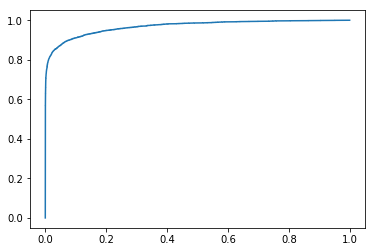

In [0]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,threshold=roc_curve(y_test_values,pred)
plt.plot(fpr,tpr)

In [0]:
auc(fpr,tpr)

0.96823931391335

In [0]:
pickle.dump(model, open( "catboost_classifier_lr01.pickle", "wb" ), protocol=4 )
!gsutil cp catboost_classifier_lr01.pickle gs://data-fraud-detection/catboost_classifier_lr01.pickle